# Lecture 16- Lab 6 Solution

We started from:

In [1]:
suits = ["Clubs", "Diamonds", "Hearts", "Spades"]
values = list(range(2,11)) + [ "Jack", "Queen", "King", "Ace"]

def make_deck():
    deck=list()
    for suit in suits:
        for value in values:
            deck.append((suit,value))
    return deck

#make_deck()

TODO:
* Players don't have a down card! Only dealer! ==> Add down card to seen cards
* Add function to show game status on screen
* Add Toggleable DEBUG printouts
* Properly handle Aces as 11 or 1
* Add logic to appropriately place shufflecard
* Check that players have chips
* Handle Dealer's visable card correctly
    
    

## Card/Deck Classes

In [50]:
class base:
    SILENT=6
    DEBUG=1
    INFO=2
    WARNING=3
    ERROR=4
    CRITICAL=5
    
    def __init__(self,level=0):
        self.level=level
        
    def message(self,level,*args):
        if level >= self.level:
            print(*args)
        

In [51]:
class Card(base):
    __suits = ["Clubs", "Diamonds", "Hearts", "Spades", "ShuffleCard"]
    __values = list(range(2,11)) + [ "Jack", "Queen", "King", "Ace"]

    def __init__(self,suit,value=None):
        base.__init__(self)
        self.__suit = suit if suit in self.__suits else None
        self.__value = value if value in self.__values else None
        
        if self.__suit is None:
            self.message(self.ERROR, "Error, bad suit:",suit)

        if self.__value is None and self.__suit != "ShuffleCard":
            self.message(self.ERROR, "Error, bad value:",value)

    def value(self):
        return self.__value
    
    def suit(self):
        return self.__suit
    
    def numerical_value(self):
        # Special Handling of aces
        if self.__value == "Ace":
            return 1
        elif self.__value in [ "Jack", "Queen", "King"]:
            return 10
        else:
            return self.__value
        
    def shuffle_card(self):
        return self.__suit == "ShuffleCard"

    def __str__(self):
        if self.shuffle_card():
            return "Shuffle Card"
        else:
            return str(self.__value) + " of " + self.__suit

    __repr__ = __str__

In [52]:
import random

class Deck(base):
    __suits = ["Clubs", "Diamonds", "Hearts", "Spades"]
    __values = list(range(2,11)) + [ "Jack", "Queen", "King", "Ace"]

    def __init__(self,n_decks=6):
        base.__init__(self)
        self.__n_decks=n_decks
        
        self.__cards = list()
        
        for _ in range(self.__n_decks):
            self.__cards.extend(self.__make_deck())            
            
        # TODO: Add logic to appropriately place shufflecard
        self.__cards.append(Card("ShuffleCard"))
        
    def __make_deck(self):
        deck=list()
        for suit in self.__suits:
            for value in self.__values:
                deck.append(Card(suit,value))
        return deck
    
    def shuffle(self):
        random.shuffle(self.__cards) 
        
    def deal(self):
        if len(self.__cards)>0:
            return self.__cards.pop()
        else:
            for _ in range(self.__n_decks):
                self.__cards.extend(self.__make_deck()) 
            self.shuffle()
            return self.__cards.pop()        


In [53]:
my_deck = Deck()
my_deck.shuffle()

[my_deck.deal() for _ in range(10)]

[Jack of Diamonds,
 10 of Spades,
 King of Clubs,
 7 of Hearts,
 Queen of Clubs,
 5 of Spades,
 3 of Hearts,
 9 of Clubs,
 8 of Hearts,
 5 of Clubs]

## Calculating Value of Hand

In [54]:
def calc_hand_value_0(hand):
    return sum(map(lambda card: card.numerical_value(),hand))

In [55]:
def calc_hand_value(hand):
    card_values = list(map(lambda card: card.numerical_value(),hand))

    n_As= len(list(filter(lambda x: x==1,card_values)))
    
    hand_value = sum(card_values)

    if n_As==0:
        return hand_value
    
    # Case the last Ace is a 1
    Ace_as_one = hand_value
    Ace_as_eleven = hand_value+10
    
    if Ace_as_eleven<=21:
        return Ace_as_eleven
    else:
        return Ace_as_one
       

In [56]:
calc_hand_value( [ Card("Clubs",10), Card("Clubs",2), Card("Hearts","Ace")] )

13

In [57]:
calc_hand_value( [ Card("Clubs",10),  Card("Hearts","Ace")] )

21

## Player Class

In [58]:
class PlayerBase(base):
    def __init__(self, name, n_chips):
        base.__init__(self)
        self.__name = name
        self.__n_chips=n_chips
    
    def name(self):
        return self.__name
    
    def chips(self):
        return self.__n_chips
    
    def pay(self,value=2):
        self.__n_chips+=value

    def deduct(self,value=2):
        # Logic to check if negative?
        self.__n_chips-=value

    def play_hand(self, down_card, up_cards, seen_cards ):
        raise NotImplementedError
        
    def __str__(self):
        return self.__name + "("+ str(self.__n_chips) + ")"
    
    __repr__=__str__
    
class DealerPlayer(PlayerBase):
    def __init__(self,threshold=16):
        self.__threshold = threshold
        PlayerBase.__init__(self,"Mr. Dealer", 1000)

    def play_hand(self, down_card, up_cards, seen_cards ):
        hand_value = calc_hand_value([down_card] + up_cards)
        return hand_value < self.__threshold
        
class ConsolePlayer(PlayerBase):
    def play_hand(self, down_card, up_cards, seen_cards ):
        print("Down Card:", down_card)
        print("Up Cards:", up_cards)
        print("Seen Cards:", seen_cards)
        hit_str= input("Hit(Y/N):")
        return hit_str.upper()=="Y"

class Strategy_1_Player(PlayerBase):
    def play_hand(self, down_card, up_cards, seen_cards ):
        return True
    
    

## Game Class

In [101]:
class Game(base):
    def __init__(self,n_decks=6):
        base.__init__(self,self.INFO)
        self.__n_decks=n_decks
        self.__players = list()
        self.__all_players = list()
        
        self.__shuffle = False
        
        
    def players(self):
        return self.__players
    
    def all_players(self):
        return self.__all_players

    def add_player(self,player):
        self.__players.append(player)
        self.__all_players.append(player)

    def deal_and_check_shuffle(self,deck):
        card = deck.deal()
        if card.shuffle_card():
            shuffle=True
            card = deck.deal()
        return card
    
    def show_status(self,hands,seen_cards):
        self.message(self.INFO,"----------------------------------------------------------------")
        self.message(self.INFO,"Hands:",hands)
        self.message(self.INFO,"Seen Cards:",seen_cards)
        self.message(self.INFO,"*************************************************")
        self.message(self.INFO,"Players:")
        self.message(self.INFO,"*************************************************")
        for i,player in enumerate(self.__all_players):
            self.message(self.INFO,i,":",player)
        self.message(self.INFO,"----------------------------------------------------------------")

        
    def play_game(self,n_hands):
        # Create Dealer
        self.add_player(DealerPlayer())
        
        deck = None
        self.__shuffle = False
        
        # TODO: Check that all players have chips... 
        
        for i_hand in range(n_hands):
            
            # Remove Players with no money
            self.__players = list(filter(lambda player: player.chips()>=2,self.__players))
            self.message(self.DEBUG,"n players, n all players",len(self.__players),len(self.__all_players))            
            self.message(self.DEBUG,"Starting Hand:",i_hand,"/",n_hands)
            # New Hand
            
            # Do we have a deck or have to shuffle?
            if deck is None or self.__shuffle:
                self.message(self.DEBUG,"Creating New Deck / Shuffling")
                deck = Deck()
                # Shuffle Cards
                deck.shuffle()
                seen_cards = list()
                self.__shuffle=False

            hands = list()

            # Deal Each Players Hand
            # Down card deal
            self.message(self.DEBUG,"Dealing Cards")
            for player_i,player in enumerate(self.__players):
                down_card = self.deal_and_check_shuffle(deck)
                up_cards = list()
                hands.append((down_card,up_cards))
                if player_i < len(self.__players)-1:
                    seen_cards.append(down_card)
                
            # Up card deal
            for (down_card,up_cards) in hands:
                up_cards.append(self.deal_and_check_shuffle(deck))                
                seen_cards.append(up_cards[-1])
                
            # TODO: Show hands...
            self.show_status(hands,seen_cards)
            
            # Play
            # Deals cards and asks players to hit/stay
            
            for player_i,((down_card,up_cards),player) in enumerate(zip(hands,self.__players)):
                self.message(self.DEBUG,"Asking Player",player_i,"to Play")
                self.message(self.DEBUG,"Player",player_i,"hand total:",calc_hand_value([down_card]+up_cards))
                hit = True
                this_hand_up_cards=list()
                while(hit):
                    hit = player.play_hand(down_card,up_cards,seen_cards)

                    if hit:
                        self.message(self.DEBUG,"Player",player_i,"Hit")
                        card = self.deal_and_check_shuffle(deck)
                        up_cards.append(card)
                        this_hand_up_cards.append(card)
                        hand_value = calc_hand_value([down_card] + up_cards)
                        self.message(self.DEBUG,"Hand Value:",hand_value)
                        if hand_value < 21:
                            hit = True
                        else: 
                            hit = False
                            if hand_value > 21:
                                self.message(self.DEBUG,"Player",player_i,"Busted")     
                            else:
                                self.message(self.DEBUG,"Player",player_i,"Got 21")
                    else:
                        self.message(self.DEBUG,"Player",player_i,"Stay")

                seen_cards.append(down_card)
                seen_cards.extend(this_hand_up_cards)

            # Pay:
            # Compute the hand values
            hand_values = [calc_hand_value([hand[0]]+hand[1]) for hand in hands]

            self.message(self.DEBUG,"Hand Values",hand_values)
            
            # Determine who gets paid
            if hand_values[-1]==21:
                self.message(self.DEBUG,"Dealer Got 21")
                for player_i,(hand_value,player) in enumerate(zip(hand_values[:-1],self.__players[:-1])):
                    if hand_value==21:
                        self.message(self.DEBUG,"Player",player_i,"Got 21. Paying 3 chips.")
                        player.pay(3)
                    else:
                        self.message(self.DEBUG,"Player",player_i,"Busted or dealer won. Deducting 2 chips.")
                        player.deduct(2)
                    
            if hand_values[-1]>21:        
                self.message(self.DEBUG,"Dealer Busted")
                for player_i,(hand_value,player) in enumerate(zip(hand_values[:-1],self.__players[:-1])):
                    if hand_value==21:
                        self.message(self.DEBUG,"Player",player_i,"Got 21. Paying 3 chips.")
                        player.pay(3)
                    elif hand_value>21:
                        self.message(self.DEBUG,"Player",player_i,"Busted. Deducting 2 chips.")
                        player.deduct(2)
                    else:
                        self.message(self.DEBUG,"Player",player_i,"Paying 2 chips.")
                        player.pay(2)
                        
            if hand_values[-1]<21:
                self.message(self.DEBUG,"Dealer hand is:",hand_values[-1])
                for player_i,(hand_value,player) in enumerate(zip(hand_values[:-1],self.__players[:-1])):
                    if hand_value==21:
                        self.message(self.DEBUG,"Player",player_i,"Got 21. Paying 3 chips.")
                        player.pay(3)
                    elif hand_value>21:
                        self.message(self.DEBUG,"Player",player_i,"Busted. Deducting 2 chips.")
                        player.deduct(2)
                    elif hand_value >  hand_values[-1]:
                        self.message(self.DEBUG,"Player",player_i," hand was",hand_value, "versus Dealer hand",
                                     hand_values[-1],"Paying 2 chips.")
                        player.pay(2)
                    else:
                        self.message(self.DEBUG,"Player",player_i," hand was",hand_value, "versus Dealer hand",
                                     hand_values[-1],"Deducting 2 chips.")
                        player.deduct(2)


In [102]:
my_game=Game()
my_game.level=Game.DEBUG

my_game.add_player(Strategy_1_Player("Dummy player",100))
my_game.add_player(ConsolePlayer("ME!",100))

#my_game.play_game(2)


## Fully Automatic Game


In [103]:
class Strategy_1_Player(PlayerBase):
    def play_hand(self, down_card, up_cards, seen_cards ):
        return True

class Strategy_2_Player(PlayerBase):
    def play_hand(self, down_card, up_cards, seen_cards ):
        """
        Assign each card a value:
        Cards 2 to 6 are +1
        Cards 7 to 9 are 0
        Cards 10 through Ace are -1
        Compute the sum of the values for all cards seen so far.
        Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.
        """                
        return True

class DealerLikePlayer(PlayerBase):
    def __init__(self,name,chips,threshold=16):
        self.__threshold = threshold
        PlayerBase.__init__(self,name, chips)

    def play_hand(self, down_card, up_cards, seen_cards ):
        hand_value = calc_hand_value([down_card] + up_cards)
        return hand_value < self.__threshold



In [129]:
my_game=Game()
my_game.level=Game.SILENT

my_game.add_player(Strategy_1_Player("Dummy player",100))
my_game.add_player(DealerLikePlayer("Stays on 13",100,13))
my_game.add_player(DealerLikePlayer("Stays on 14",100,14))
my_game.add_player(DealerLikePlayer("Stays on 15",100,15))
my_game.add_player(DealerLikePlayer("Stays on 16",100,16))
my_game.add_player(DealerLikePlayer("Stays on 17",100,17))
my_game.add_player(DealerLikePlayer("Stays on 18",100,18))
my_game.add_player(DealerLikePlayer("Stays on 19",100,19))
my_game.add_player(DealerLikePlayer("Stays on 20",100,20))


my_game.play_game(10)


In [105]:
[player.chips() for player in my_game.players()]

[95, 97, 93, 99, 1000]

In [130]:
def play_a_round(n_hands=50):
    my_game=Game()
    my_game.level=Game.ERROR

    my_game.add_player(Strategy_1_Player("Dummy player",100))
    my_game.add_player(DealerLikePlayer("Stays on 13",100,13))
    my_game.add_player(DealerLikePlayer("Stays on 14",100,14))
    my_game.add_player(DealerLikePlayer("Stays on 15",100,15))
    my_game.add_player(DealerLikePlayer("Stays on 16",100,16))
    my_game.add_player(DealerLikePlayer("Stays on 17",100,17))
    my_game.add_player(DealerLikePlayer("Stays on 18",100,18))
    my_game.add_player(DealerLikePlayer("Stays on 19",100,19))
    my_game.add_player(DealerLikePlayer("Stays on 20",100,20))
    
    my_game.play_game(n_hands)
    
    return [player.chips() for player in my_game.all_players()]
    

In [107]:
results=play_a_round(100)

In [108]:
results

[0, 75, 110, 73, 1000]

In [131]:
def play_many_rounds(n_rounds=100,n_hands=50):
    
    results = list()
    
    for i_round in range(n_rounds):
        results.append(play_a_round(n_hands))
        
    return results

In [132]:
results= play_many_rounds(1000)

In [133]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [137]:
res = np.array(results)
res = res [:,:-1]

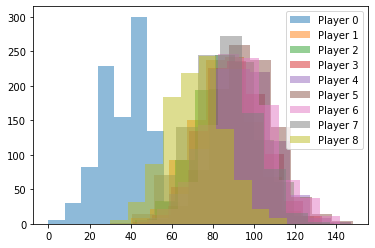

In [139]:
for i in range(res.shape[1]):
    plt.hist(res[:,i],label="Player "+str(i),alpha=0.5)
    
plt.legend()
plt.show()


In [143]:
m=np.mean(res,axis=0)

In [144]:
s=np.std(res,axis=0)

<ErrorbarContainer object of 3 artists>

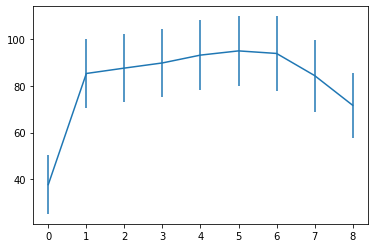

In [145]:
plt.errorbar(range(len(m)),m,s)